### Training Vlads model by first stacking the depths from the Sota models

In [1]:
import sys, os
import torch, wandb
import torch.nn as nn
from torch.utils.data import DataLoader
sys.path.append(os.path.abspath(os.path.join(os.curdir, '..')))
from configs import extended_unet_config as config
from models.unet_convnextv2 import Unet
from datasets.combination_depth_dataset import CombDepthDataset
from utils.train_utils import train_model
import utils.train_utils as tu
from utils.train_utils import evaluate_model
import importlib

/home/v.lomtev/env/python3.12_vlad/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/v.lomtev/env/python3.12_vlad/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/v.lomtev/env/python3.12_vlad/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Set a fixed random seed for reproducibility
torch.manual_seed(config.random_seed)

train_full_dataset = CombDepthDataset(
    data_dir=os.path.join(config.dataset_path, 'train/train'),
    depths_dir=config.depth_maps_path,
    list_file=os.path.join(config.dataset_path, 'train_list.txt'),
    transform=config.padded_transform,
    target_transform=config.target_transform,
    has_gt=True,
    depth_model_names=config.depth_model_names,
    uncertainty_dir=None,
    use_uncertainty=None)
    
    # Create test dataset without ground truth
test_dataset = CombDepthDataset(
    data_dir=os.path.join(config.dataset_path, 'test/test'),
    depths_dir=os.path.join(config.depth_maps_path, 'test'),
    list_file=os.path.join(config.dataset_path, 'test_list.txt'),
    transform=config.padded_transform,
    has_gt=False,
    depth_model_names=config.depth_model_names,
    uncertainty_dir=None,
    use_uncertainty=None)  # Test set has no ground truth
    
# Split training dataset into train and validation
total_size = len(train_full_dataset)
train_size = int((1-config.val_part) * total_size)  
val_size = total_size - train_size    
    
train_dataset, val_dataset = torch.utils.data.random_split(
    train_full_dataset, [train_size, val_size]
)
#val_dataset.transform = config.transform_val # I dont think we need to use augmentations for validation


# Create data loaders with memory optimizations
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.train_bs, 
    shuffle=True, 
    num_workers=config.num_workers, 
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
)
    
    
val_loader = DataLoader(
    val_dataset, 
    batch_size=config.val_bs, 
    shuffle=False, 
    num_workers=config.num_workers, 
    pin_memory=True
)
    
test_loader = DataLoader(
    test_dataset, 
    batch_size=config.val_bs, 
    shuffle=False, 
    num_workers=config.num_workers, 
    pin_memory=True
)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 20375, Validation size: 3596, Test size: 650


In [3]:
model = config.model()


optimizer = config.optimizer(model.parameters())
print(f"Using device: {config.device}")

Num channels: 7
Using device: cuda:3


In [4]:
#exp_name = "extended_unet_sota_depths"
#model.load_state_dict(torch.load(f'{os.path.join(config.dataset_path, exp_name)}/best_model_43.pt'))

In [ ]:
# Wandb logging
exp_name = "extended_unet_sota_depths_nopretrain"

print("Starting training...")
with wandb.init(project="MonocularDepthEstimation",  #CIL
                save_code=True,
                notes=config.WANDB_NOTES):
    model = train_model(model, train_loader, val_loader,
                        config.loss, optimizer, 50, config.device,
                       exp_path=os.path.join(config.dataset_path, exp_name),
                       is_extended_model=True, use_uncertainty_map=False)

Starting training...


wandb: Currently logged in as: noloo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [01:46<00:00,  2.12it/s]


Train Loss: 0.3399, Validation Loss: 0.3779
New best model saved at epoch 1 with validation loss: 0.3779
Epoch 2/50


Training:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1571/2546 [14:01<08:48,  1.84it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [01:43<00:00,  2.16it/s]


Train Loss: 0.2083, Validation Loss: 0.2280
Epoch 5/50


Training:   8%|███████████▊                                                                                                                                              | 196/2546 [01:45<20:43,  1.89it/s]

In [15]:
%load_ext autoreload
%autoreload 2

In [5]:
import datasets
importlib.reload(datasets)

<module 'datasets' (namespace) from ['/home/v.lomtev/CIL/CIL_2025/datasets', '/home/v.lomtev/CIL/CIL_2025/datasets', '/home/v.lomtev/CIL/CIL_2025/datasets']>

In [6]:

test_dataset = datasets.combination_depth_dataset.CombDepthDataset(
    data_dir=os.path.join(config.dataset_path, 'test/test'),
    depths_dir=os.path.join(config.depth_maps_path, 'test'),
    list_file=os.path.join(config.dataset_path, 'test_list.txt'),
    transform=config.padded_transform,
    has_gt=False,
    depth_model_names=config.depth_model_names,
    uncertainty_dir=None,
    use_uncertainty=None)  # Test set has no ground truth
test_loader = DataLoader(
    test_dataset, 
    batch_size=config.val_bs, 
    shuffle=False, 
    num_workers=config.num_workers, 
    pin_memory=True
)

In [8]:
import utils.train_utils as tu
tu.generate_test_predictions(model, test_loader, config.device,
                          exp_path=os.path.join(config.dataset_path, exp_name),
                            is_exntended_model=True)

Generating Test Predictions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:20<00:00,  1.96it/s]


Generating Test Predictions:  46%|███████████████████████████████████████████████████████████████▉                                                                          | 19/41 [04:42<05:26, 14.85s/it]


KeyboardInterrupt: 

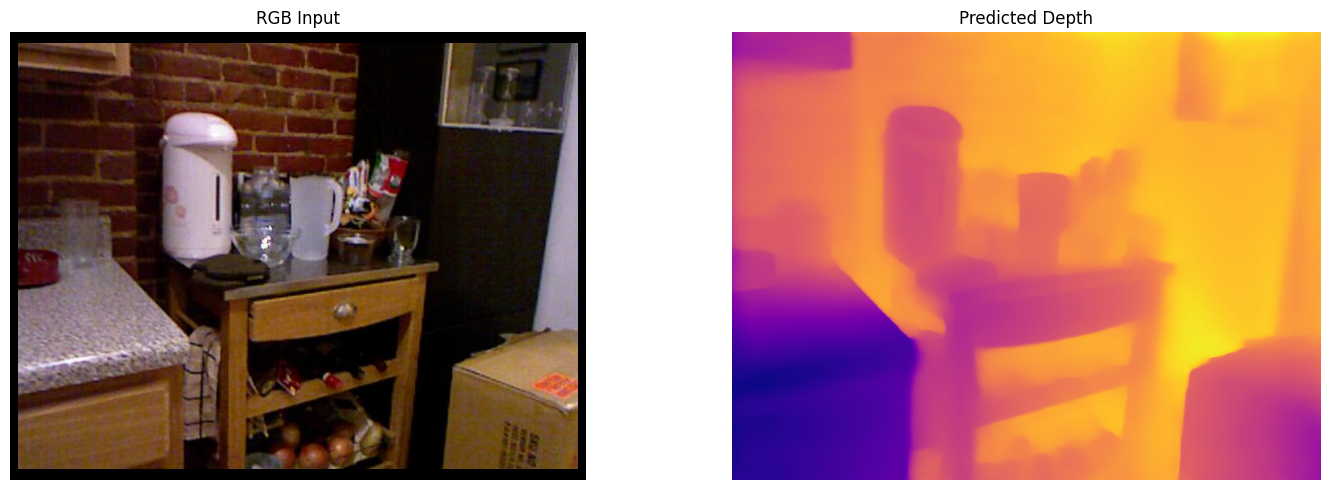

In [11]:

importlib.reload(tu)
tu.visualize_test_predictions(model, test_loader, config.device,
                              exp_path=os.path.join(config.dataset_path, exp_name), is_exntended_model=True)